In [2]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

# Keras imports
from keras.models import Model
from keras import backend as K

# ML4CVD Imports
sys.path.append("../ml4cvd")
from arguments import parse_args
from models import make_multimodal_to_multilabel_model, train_model_from_generators
from tensor_generators import big_batch_from_minibatch_generator, test_train_valid_tensor_generators

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def gradients_from_output(args, model, output_layer, output_index):
    K.set_learning_phase(1)
    input_tensor = model.input
    x = model.get_layer(output_layer).output[:,output_index]

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(x, input_tensor)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-6)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_tensor], [x, grads])
    return iterate


def saliency_map(input_tensor, model, output_layer, output_index):
    get_gradients = gradients_from_output(args, model, output_layer, output_index)
    activation, grads = get_gradients([input_tensor])
    print('Activation is:', activation, 'gradient shape:', grads.shape)
    if len(input_tensor.shape) == 4:
        plt.imshow(grads[0, :, :, 0])
    elif len(input_tensor.shape) == 3:
        plt.plot(grads[0,:,:].flatten('F'))
    return grads

In [3]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/pix-size-tensors/2019-04-29/', 
            '--input_tensors', 'mri_slice', 
            '--output_tensors', 'end_systole_volume',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/mri_slice_esv.hd5',
            '--id', 'mri_slice_esv']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-07 15:25:17,154 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/mri_slice_esv/log_2019-05-07_15-25_0.log.
2019-05-07 15:25:17,155 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773, 3

2019-05-07 15:25:24,745 - tensor_generators:222 - INFO - Input tensor 'input_mri_slice' has shape (6, 256, 256, 1)
2019-05-07 15:25:24,746 - tensor_generators:225 - INFO - Output tensor 'output_end_systole_volume_continuous' has shape (6, 1)


(6, 256, 256, 1) (1, 256, 256, 1)


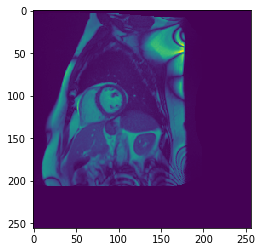

In [4]:
test_tensor = test_data['input_mri_slice']
print(test_tensor.shape, test_tensor[:1].shape)
plt.imshow(test_tensor[0, :, :, 0])

Activation is: [0.99511856] gradient shape: (1, 256, 256, 1)


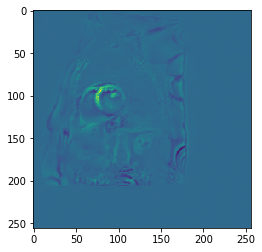

In [5]:
grads = saliency_map(test_tensor[:1], model, 'output_end_systole_volume_continuous', 0)

In [3]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/ecg-text3/2019-04-26/', 
            '--input_tensors', 'ecg_rest_1lead', 
            '--output_tensors', 'ecg_rhythm',
            '--batch_size', '6',
            '--epochs', '2',  
            '--learning_rate', '0.001',
            '--training_steps', '128',
            '--validation_steps', '10',
            '--test_steps', '1',
            '--model_file', '/home/sam/ml/trained_models/ecg_1lead_rhythm_only/ecg_1lead_rhythm_only.hd5',
            '--id', 'ecg_1lead_rhythm_only']
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,
                                                                                       args.tensor_maps_out,
                                                                                       args.tensors, args.batch_size,
                                                                                       args.valid_ratio,
                                                                                       args.test_ratio,
                                                                                       args.icd_csv,
                                                                                       args.balance_by_icds)

model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-05-07 17:41:08,952 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/ecg_1lead_rhythm_only/log_2019-05-07_17-41_0.log.
2019-05-07 17:41:08,954 - arguments:231 - INFO - Total TensorMaps:1237 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=6, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637,

2019-05-07 17:41:15,907 - tensor_generators:222 - INFO - Input tensor 'input_strip_ecg_rest' has shape (6, 600, 8)
2019-05-07 17:41:15,908 - tensor_generators:225 - INFO - Output tensor 'output_ecg_rhythm_categorical' has shape (6, 4)


(6, 600, 8) (1, 600, 8)


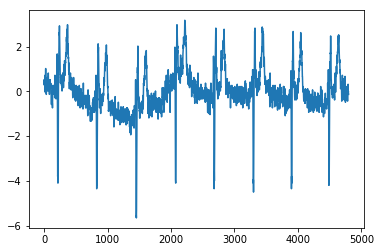

In [8]:
test_tensor = test_data['input_strip_ecg_rest']
print(test_tensor.shape, test_tensor[:1].shape)
plt.plot(test_tensor[0,:,:].flatten('F'))

In [16]:
Image('./recipes_output/ecg_rest_wave_regress_afib_1lead/write_filters/conv1d_8_filter_16.png')